In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score 

d:\App\Anaconda3\envs\pytorch-gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\App\Anaconda3\envs\pytorch-gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 390/390 [00:04<00:00, 90.93it/s]


Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Classification report:
                   precision    recall  f1-score   support

     Ariel Sharon       0.87      0.68      0.76        19
     Colin Powell       0.80      0.93      0.86        59
  Donald Rumsfeld       0.75      0.70      0.72        30
    George W Bush       0.92      0.92      0.92       133
Gerhard Schroeder       0.76      0.81      0.79        27
      Hugo Chavez       0.92      0.67      0.77        18
   Jacques Chirac       0.73      0.62      0.67        13
    Jean Chretien       0.79      0.79      0.79        14
    John Ashcroft       0.67      0.92      0.77        13
Junichiro Koizumi       1.00      0.80      0.89        15
  Serena Williams       0.89      0.62      0.73        13
       Tony Blair       0.77      0.83      0.80        36

         accuracy                           0.84       390
        macro avg       0.82      0.77      0.79       390
     weighted avg       0.84

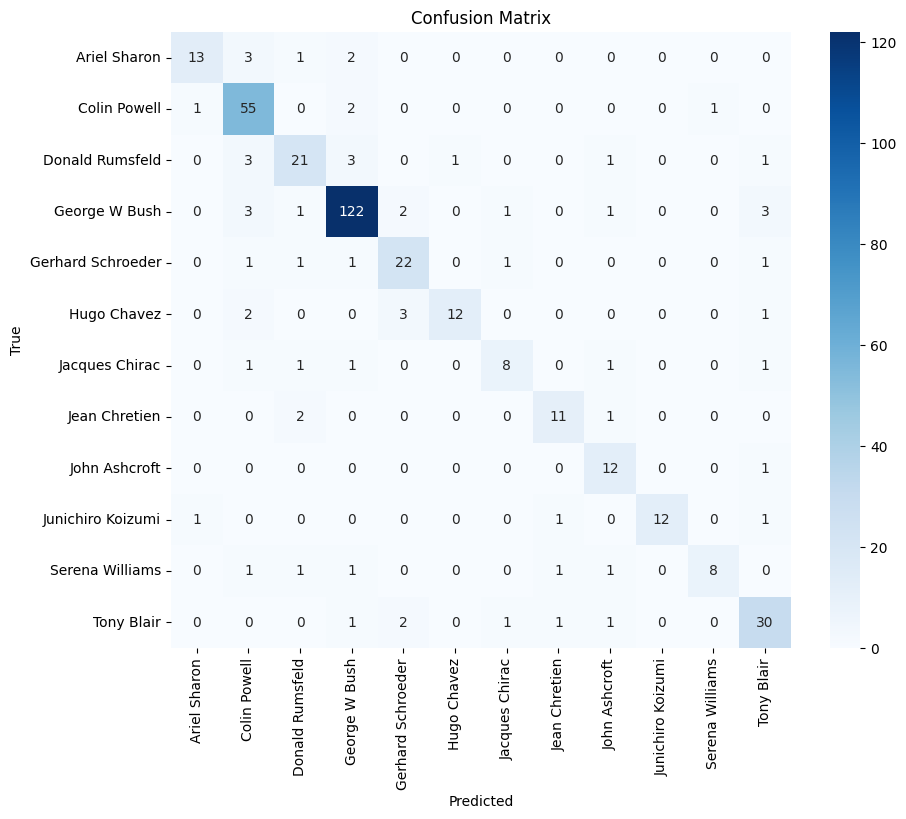

0.8358974358974359

In [5]:
# 1. 导入必要的库（确保已导入这些库）
import numpy as np
import torch
import torchvision.transforms as transforms
from tqdm import tqdm

# 2. 加载数据集
lfw_dataset = fetch_lfw_people(min_faces_per_person=50, resize=0.4)
X = lfw_dataset.images
y = lfw_dataset.target
target_names = lfw_dataset.target_names
n_classes = target_names.shape[0]

# 3. 数据预处理
n_samples, h, w = X.shape
X_flat = X.reshape(n_samples, -1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. 分割数据集
X_train_flat, X_test_flat, X_train_img, X_test_img, y_train, y_test = train_test_split(
    X_flat, X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

# 5. 提取 EigenFace 特征（代码与之前相同）
scaler = StandardScaler()
X_train_flat_scaled = scaler.fit_transform(X_train_flat)
X_test_flat_scaled = scaler.transform(X_test_flat)
n_components_pca = 150
pca = PCA(n_components=n_components_pca, svd_solver='randomized', whiten=True)
X_train_pca = pca.fit_transform(X_train_flat_scaled)
X_test_pca = pca.transform(X_test_flat_scaled)

# 6. 提取 FisherFace 特征（代码与之前相同）
lda = LDA(n_components=n_classes - 1)
X_train_lda = lda.fit_transform(X_train_pca, y_train)
X_test_lda = lda.transform(X_test_pca)

# 7. 提取 ResNet 特征（修改部分）
# 定义图像预处理
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # 预训练 ResNet 模型的均值
        std=[0.229, 0.224, 0.225]     # 预训练 ResNet 模型的标准差
    ),
])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet = models.resnet50(pretrained=True)
resnet = resnet.to(device)
resnet.eval()
resnet_feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
resnet_feature_extractor = resnet_feature_extractor.to(device)

def extract_resnet_features(X_images):
    features = []
    with torch.no_grad():
        for img in tqdm(X_images):
            img_rgb = np.stack([img, img, img], axis=2)  # 灰度图转为 RGB
            img_rgb = img_rgb.astype(np.uint8)  # 转换数据类型为 uint8
            img_tensor = transform(img_rgb)
            img_tensor = img_tensor.unsqueeze(0).to(device)
            feature = resnet_feature_extractor(img_tensor)
            feature_np = feature.cpu().numpy().flatten()
            features.append(feature_np)
    return np.array(features)

X_train_resnet = extract_resnet_features(X_train_img)
X_test_resnet = extract_resnet_features(X_test_img)

# 8. 特征融合（代码与之前相同）
from sklearn.preprocessing import normalize
X_train_pca_norm = normalize(X_train_pca)
X_test_pca_norm = normalize(X_test_pca)
X_train_lda_norm = normalize(X_train_lda)
X_test_lda_norm = normalize(X_test_lda)
X_train_resnet_norm = normalize(X_train_resnet)
X_test_resnet_norm = normalize(X_test_resnet)
X_train_combined = np.hstack((X_train_pca_norm, X_train_lda_norm, X_train_resnet_norm))
X_test_combined = np.hstack((X_test_pca_norm, X_test_lda_norm, X_test_resnet_norm))

# 9. 分类器训练和优化（代码与之前相同）
param_grid = {
    'C': [1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}
clf = GridSearchCV(SVC(class_weight='balanced', probability=True), param_grid, cv=5)
clf.fit(X_train_combined, y_train)
print(f"Best parameters: {clf.best_params_}")

# 10. 模型评估（代码与之前相同）
y_pred = clf.predict(X_test_combined)
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# 绘制混淆矩阵（代码与之前相同）
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

accuracy_score(y_test, y_pred)